In [2]:
pip install numpy matplotlib pandas

Note: you may need to restart the kernel to use updated packages.


In [66]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

The dataset contains two features -

throughput (mb/s) and
latency (ms) of response of each server.

In [67]:
X_train = pd.read_csv("AnomalyData/tr_server_data.csv", header=None ).to_numpy()
X_val = pd.read_csv("AnomalyData/cv_server_data.csv", header=None).to_numpy()
y_val = pd.read_csv("AnomalyData/gt_server_data.csv", header=None).to_numpy().flatten()

In [68]:
# Display the first five elements of X_train
print("The first 5 elements of X_train are:\n", X_train[:5]) 

The first 5 elements of X_train are:
 [[13.047 14.741]
 [13.409 13.763]
 [14.196 15.853]
 [14.915 16.174]
 [13.577 14.043]]


In [69]:
# Display the first five elements of X_val
print("The first 5 elements of X_val are\n", X_val[:5]) 

The first 5 elements of X_val are
 [[15.79  14.921]
 [13.64  15.33 ]
 [14.866 16.474]
 [13.585 13.989]
 [13.464 15.635]]


In [70]:
# Display the first five elements of y_val
print("The first 5 elements of y_val are\n", y_val[:5])  

The first 5 elements of y_val are
 [0 0 0 0 0]


In [71]:
print ('The shape of X_train is:', X_train.shape)
print ('The shape of X_val is:', X_val.shape)
print ('The shape of y_val is: ', y_val.shape)

The shape of X_train is: (307, 2)
The shape of X_val is: (307, 2)
The shape of y_val is:  (307,)


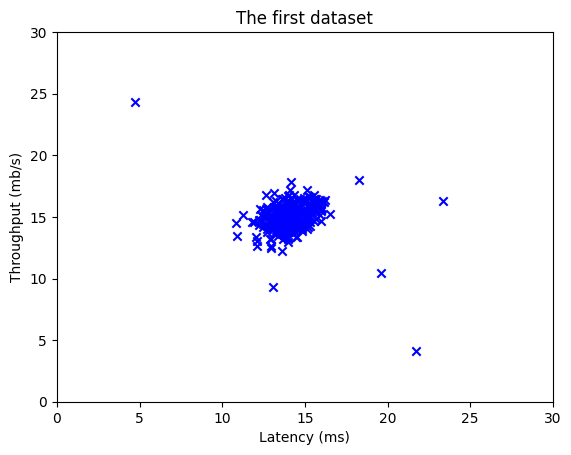

In [72]:
# Create a scatter plot of the data. To change the markers to blue "x",
# we used the 'marker' and 'c' parameters
plt.scatter(X_train[:, 0], X_train[:, 1], marker='x', c='b') 

# Set the title
plt.title("The first dataset")
# Set the y-axis label
plt.ylabel('Throughput (mb/s)')
# Set the x-axis label
plt.xlabel('Latency (ms)')
# Set axis range
plt.axis([0, 30, 0, 30])
plt.show()

Estimating parameters for a Gaussian distribution

In [73]:
def estimate_gaussian(X): 
    """
    Calculates mean and variance of all features 
    in the dataset
    
    Args:
        X (ndarray): (m, n) Data matrix
    
    Returns:
        mu (ndarray): (n,) Mean of all features
        var (ndarray): (n,) Variance of all features
    """

    m, n = X.shape
    
     # Compute the mean of each feature (column)
    # axis=0 means we collapse the rows (m) and get one value per column
    mu = np.mean(X, axis=0)
    
    # Compute the variance of each feature
    # By default, np.var divides by m (Population Variance), which is correct for MLE
    var = np.var(X, axis=0)
    
    return mu, var

In [74]:
# Estimate mean and variance of each feature
mu, var = estimate_gaussian(X_train)              

print("Mean of each feature:", mu)
print("Variance of each feature:", var)

Mean of each feature: [14.11225277 14.99767459]
Variance of each feature: [1.8326777  1.70971534]


In [75]:
def multivariate_gaussian(X, mu, var):
    """
    Computes the probability density function of the examples X under
    the multivariate gaussian distribution with parameters mu and var. 
    
    Args:
        X (ndarray): (m, n) Data matrix
        mu (ndarray): (n,) Mean of each feature
        var (ndarray): (n,) Variance vector OR (n, n) Covariance matrix
        
    Returns:
        p (ndarray): (m,) Probability density for each example
    """
    
    k = len(mu)
    
    # If var is a vector (1D), convert it to a diagonal covariance matrix
    if var.ndim == 1:
        var = np.diag(var)

    # 1. Center the data
    X = X - mu

    # 2. Calculate the scaling factor: (2 * pi)^(-k/2) * det(Sigma)^(-0.5)
    # We use the determinant of the covariance matrix
    scaling_factor = (2 * np.pi)**(-k/2) * np.linalg.det(var)**(-0.5)
    
    # 3. Calculate the exponent: -0.5 * (x-mu)^T * Sigma^-1 * (x-mu)
    # We use pseudo-inverse (pinv) for numerical stability
    Sigma_inv = np.linalg.pinv(var)
    
    # This matrix multiplication calculates the term inside the exponent for all examples
    # (X @ Sigma_inv) * X performs the (x-mu)^T * Sigma^-1 * (x-mu) logic
    exponent_term = -0.5 * np.sum(np.matmul(X, Sigma_inv) * X, axis=1)
    
    # 4. Combine them
    p = scaling_factor * np.exp(exponent_term)
    
    return p

In [76]:
def select_threshold(y_val, p_val): 
    """
    Finds the best threshold to use for selecting outliers 
    based on the results from a validation set (p_val) 
    and the ground truth (y_val)
    
    Args:
        y_val (ndarray): Ground truth on validation set
        p_val (ndarray): Results on validation set
        
    Returns:
        epsilon (float): Threshold chosen 
        F1 (float):      F1 score by choosing epsilon as threshold
    """ 

    best_epsilon = 0
    best_F1 = 0
    F1 = 0
    
    step_size = (max(p_val) - min(p_val)) / 1000
    
    for epsilon in np.arange(min(p_val), max(p_val), step_size):
    
        # 1. Create predictions based on the current epsilon
        # If probability < epsilon, we predict it's an anomaly (1). Otherwise normal (0).
        predictions = (p_val < epsilon)
        
        # 2. Calculate True Positives (tp), False Positives (fp), False Negatives (fn)
        # tp: predicted = 1 and actual = 1
        tp = np.sum((predictions == 1) & (y_val == 1))
        
        # fp: predicted = 1 but actual = 0
        fp = np.sum((predictions == 1) & (y_val == 0))
        
        # fn: predicted = 0 but actual = 1
        fn = np.sum((predictions == 0) & (y_val == 1))
        
        # 3. Calculate Precision and Recall
        # Handle division by zero edge cases
        prec = tp / (tp + fp) if (tp + fp) > 0 else 0
        rec = tp / (tp + fn) if (tp + fn) > 0 else 0
        
        # 4. Calculate F1 Score
        if (prec + rec) > 0:
            F1 = 2 * prec * rec / (prec + rec)
        else:
            F1 = 0
    
        
        if F1 > best_F1:
            best_F1 = F1
            best_epsilon = epsilon
        
    return best_epsilon, best_F1

The low probability examples are more likely to be the anomalies in our dataset.
One way to determine which examples are anomalies is to select a threshold based on a cross validation set.


In [77]:
p_val = multivariate_gaussian(X_val, mu, var)
epsilon, F1 = select_threshold(y_val, p_val)
print (p_val[:5])
print('Best epsilon found using cross-validation: %e' % epsilon)
print('Best F1 on Cross Validation Set: %f' % F1)

[0.04164367 0.08191497 0.04070809 0.06189501 0.07119262]
Best epsilon found using cross-validation: 8.990837e-05
Best F1 on Cross Validation Set: 0.875000


# Anomalies found: 6


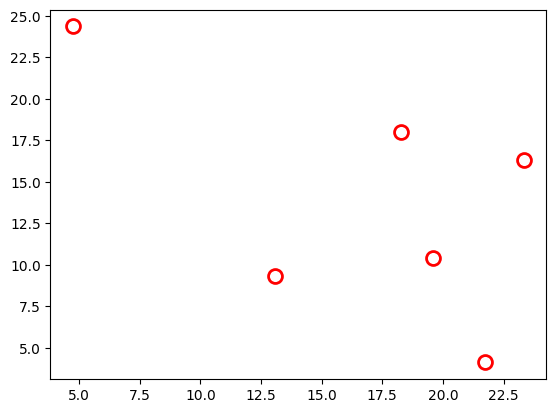

In [78]:
# Find the outliers in the training set


p = multivariate_gaussian(X_train, mu, var)
outliers = p < epsilon
print('# Anomalies found: %d'% sum(p < epsilon))

# Draw a red circle around those outliers
plt.plot(X_train[outliers, 0], X_train[outliers, 1], 'ro',
         markersize= 10,markerfacecolor='none', markeredgewidth=2)

# Anomalies found: 6


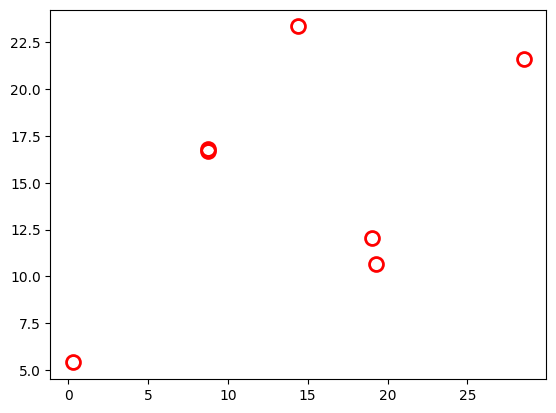

In [79]:
# Find the outliers in the validation set 
p_val = multivariate_gaussian(X_val, mu, var)
outliers = p_val < epsilon
print('# Anomalies found: %d'% sum(p < epsilon))

# Draw a red circle around those outliers
plt.plot(X_val[outliers, 0], X_val[outliers, 1], 'ro',
         markersize= 10,markerfacecolor='none', markeredgewidth=2)